In [1]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings

import statsmodels.api as sm
from scipy.stats import norm

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024"

# Data preocessing Parker cohort

In [2]:
#Readin samples from Parker cohort of Infinity TB all_cols.csv file shared by Jing 
df_parker = pd.read_csv("/ghsfa/projects/pharma/customers/ParkerInstitutePICI/Infinity/PIC_RP_01_Infinity/PIC_RP_01_Infinity_02/data/report/3rd_run/12252023_PIC_RP01_02_tb_changed_all_cols.csv", header = 1) 

print("Total sample size of Parker cohort is " + str(df_parker.shape[0]) + "\n") 
print("Total unique sample size of Parker cohort is " + str(df_parker.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of Parker cohort is " + str(df_parker.Patient_ID.nunique()) + "\n")
df_parker.head()

Total sample size of Parker cohort is 105742

Total unique sample size of Parker cohort is 1409

Total unique patient sample size of Parker cohort is 548



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Study ID,Patient ID,Customer Sample ID,Sample Time point,plasma_volume_manifest,Sample Type,Cancer Stage,requestcreatedt,bloodcolldate,sample_received_date,cancerother,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,plasma_volume_observed,Batch_ID,new_Cancertype,Cancer_Type_in_Cohort,new_Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_Standardized,call,ldt_reportable,ruo_reportable,variant_comment,Final_RUO_call,on_OMNI,on_G360,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,cn_deletion_sample_comment,cnv_tumor_fraction,hyper_score,on_target_dmr_count,off_target_dmr_count,total_dmr_count,hyper_flag,runid,chry_nonsingleton,contam_vscore,dinucleosome_peak,dm_probes,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_95_lower,methyl_95_upper,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,sample_contamination_pct,sample_coverage_exceptions_ldt,warning,num_fusion_in_homdel,num_somvar_in_homdel,methyl_pos_capture_min
0,PICI0009,BK14846EP01,A0723619,B00538703,PICI0009.PICI0009-3-1309,12 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,SNV,NaN,SESN2,1,28595751.0,2.0,V50M,G>A,c.148G>A,NM_031459.5,52.98,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV53429244,rs148732943,NaN,NaN,NaN,NaN,3223.0,19.56,NaN,NaN,Detected,0.110817,11.34,Low,Not Detected,18.616,1.0,0.0,03/14/2023,08/07/2020,12/25/2023,Urothelial carcinoma (UC),Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1309,BK14846EP01,12 MONTHS POST 1ST DOSE,1.0,Plasma,NaN,04/13/2023,08/07/2020,03/14/2023,Urothelial carcinoma (UC),NaN,ACCCATTGCA,GGTCCTCTCA,Shortened_Targeted_SEQ,EIO_PlateI_A11,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,A11,1.0,PS3C-255,Urothelial carcinoma (UC),NaN,NaN,NaN,NaN,1.0,0.0,1.0,germline pval,1.0,Yes,No,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.248991,3.0,2.0,BREAST,24.64775,37.1925,24.64775,20.74831,22.46395,6,NaN,0.19,6,77,0,77,NaN,231118_A01907_0174_BHKJHYDSX7,0.0,2.0,322.0,77.0,0.00133,2766.0,1.246,0.83,0.04,12.0,12.0,133364.0,0.000037,1.21366,0.02,2.0,NaN,NaN,NaN,1.21366
1,PICI0009,BK14846EP01,A0723619,B00538703,PICI0009.PICI0009-3-1309,12 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,SNV,NaN,KMT2B,19,36223413.0,28.0,A1988G,C>G,c.5963C>G,NM_014727.3,52.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3042.0,19.56,NaN,NaN,Detected,0.110817,11.34,Low,Not Detected,18.616,1.0,0.0,03/14/2023,08/07/2020,12/25/2023,Urothelial carcinoma (UC),Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1309,BK14846EP01,12 MONTHS POST 1ST DOSE,1.0,Plasma,NaN,04/13/2023,08/07/2020,03/14/2023,Urothelial carcinoma (UC),NaN,ACCCATTGCA,GGTCCTCTCA,Shortened_Targeted_SEQ,EIO_PlateI_A11,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,A11,1.0,PS3C-255,Urothelial carcinoma (UC),NaN,NaN,NaN,NaN,1.0,0.0,1.0,germline pval,1.0,No,No,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.248991,3.0,2.0,BREAST,24.64775,37.19

In [3]:
#Readin a subset Parker samples. Mingyang selected 914 out of 1409 samples as no QC warnings triggered.
#MY also ran the MB Lung v1, MB pan cancer caller on those 914 samples and added some columns to indicate the result
df_parker_clean = pd.read_csv("/ghsfa/projects/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer/parker_914_clean_samples_meta.csv", header = 0) 

print("Total sample size of Parker cohort w/t QC warnings is " + str(df_parker_clean.shape[0]) + "\n") 
print("Total unique sample size of Parker cohort w/t QC warnings is " + str(df_parker_clean.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of Parker cohort w/t QC warnings is " + str(df_parker_clean.Patient_ID.nunique()) + "\n")
df_parker_clean.head()

Total sample size of Parker cohort w/t QC warnings is 914

Total unique sample size of Parker cohort w/t QC warnings is 914

Total unique patient sample size of Parker cohort w/t QC warnings is 463



,warning,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,HRD_score,hrd_status,Max_percentage,cfDNA_ng,Plasma_ml_input,Cancertype,fc_dir,runid,chry_nonsingleton,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,cn_deletion_sample_comment,new_Cancertype,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,methyl_95_lower,methyl_95_upper,dinucleosome_peak,dm_probes,on_target_dmr_count,off_target_dmr_count,run_sample_id,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer,methyl_call_LR_Aggregated,new_Visit_name
0,NaN,A0723619,B00538703,PICI0009.PICI0009-3-1309,12 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,Detected,0.110817,11.34,Low,Not Detected,NaN,HRD_Neg,19.56,18.616,1.0,Urothelial carcinoma (UC),/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,2.0,0.00133,2766.0,1.246,0.83,0.04,133364.0,0.000037,1.21366,1.21366,0.02,NaN,Urothelial carcinoma (UC),BREAST,24.64775,37.19250,24.64775,20.74831,22.46395,12.0,12.0,322.0,77.0,77,0,B00538703,11.477615,-20.032878,1,8.147645,-20.86299,1,1,12 months post 1st dose
1,NaN,A0723616,B00538698,PICI0009.PICI0009-3-1773,PRE-TREATMENT,1,SUCCESS,NaN,Detected,0.005843,30.81,High,Not Detected,NaN,HRD_Neg,0.58,8.528,1.0,Urothelial carcinoma (UC),/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,0.0,0.00000,1248.0,1.422,0.84,0.06,63071.0,0.000396,1.21098,1.21098,0.02,NaN,Urothelial carcinoma (UC),LUNG,10.42780,23.50968,8.35169,3.48606,10.42780,12.0,12.0,324.0,0.0,0,0,B00538698,-6.316503,-20.032878,1,-2.500514,-20.86299,1,1,pre-treatment
2,NaN,A0723615,B00538701,PICI0009.PICI0009-3-1721,PRE-TREATMENT,1,SUCCESS,NaN,Detected,0.000910,7.56,Low,Not Detected,NaN,HRD_Neg,6.26,7.436,1.0,Bladder cancer,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,0.0,0.00000,987.0,2.003,0.84,0.06,52108.0,0.000038,1.23931,1.23931,0.02,NaN,Bladder cancer,LUNG,0.05464,-0.03561,-14.06017,-10.61117,0.05464,12.0,12.0,319.0,1.0,0,1,B00538701,-21.017365,-20.032878,0,-21.892035,-20.86299,0,1,pre-treatment
3,NaN,A0723613,B00538687,PICI0009.PICI0009-3-1007,4-6 WEEKS POST EOSI,1,SUCCESS,NaN,Detected,0.001187,16.32,Low,Not Detected,NaN,HRD_Neg,0.81,6.136,1.0,Renal cell carcinoma (RCC),/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,1.0,0.00411,968.0,1.071,0.85,0.05,43561.0,0.000207,1.22899,1.22899,0.02,NaN,Renal cell carcinoma (RCC),LUNG,0.29922,4.37834,-0.29118,-2.92178,0.29922,12.0,12.0,321.0,0.0,0,0,B00538687,-18.545455,-20.032878,1,-22.245143,-20.86299,0,1,4-6 weeks post eosi
4,NaN,A0723611,B00538690,PICI0009.PICI0009-3-1772,PRE-TREATMENT,1,SUCCESS,NaN,Detected,0.669596,8.51,Low,Detected,NaN,HRD_Pos,54.65,483.600,1.0,Prostate cancer,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,4.0,0.00153,2968.0,0.970,0.85,0.09,107226.0,0.000019,1.27363,1.27363,0.02,NaN,Prostate cancer,BREAST,42.03898,15.37511,42.03898,24.49356,26.79190,12.0,12.0,299.0,372.0,345,27,B00538690,14.107403,-20.032878,1,12.676551,-20.86299,1,1,pre-treatment


Total sample size wtih positive on MB pan-cancer caller is 538

Total sample size wtih positive on MB lung v1 caller is 573

Total sample size wtih positive on LR aggregative caller is 571



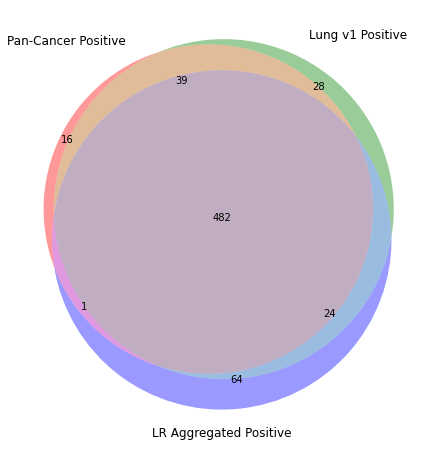

Total sample size used for ISD is 98

Total sample size used for ISD with MB/LR caller info is 98



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Study ID,Patient ID,Customer Sample ID,Sample Time point,plasma_volume_manifest,Sample Type,Cancer Stage,requestcreatedt,bloodcolldate,sample_received_date,cancerother,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,plasma_volume_observed,Batch_ID,new_Cancertype,Cancer_Type_in_Cohort,new_Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_Standardized,call,ldt_reportable,ruo_reportable,variant_comment,Final_RUO_call,on_OMNI,on_G360,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,cn_deletion_sample_comment,cnv_tumor_fraction,hyper_score,on_target_dmr_count,off_target_dmr_count,total_dmr_count,hyper_flag,runid,chry_nonsingleton,contam_vscore,dinucleosome_peak,dm_probes,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_95_lower,methyl_95_upper,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,sample_contamination_pct,sample_coverage_exceptions_ldt,warning,num_fusion_in_homdel,num_somvar_in_homdel,methyl_pos_capture_min,maf
2317,PICI0009,BK15032EP01,A0723584,B00538617,PICI0009.PICI0009-3-1876,PRE-TREATMENT,1,SUCCESS,NaN,SNV,NaN,PIK3CA,3,178952085.0,21.0,H1047R,A>G,c.3140A>G,NM_006218.4,14.60,NaN,somatic,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55873195,rs121913279,Pathogenic,28691.0,deleterious,NaN,4693.0,16.27,NaN,NaN,Detected,0.083369,6.62,Low,Not Detected,29.016,1.0,0.0,03/14/2023,09/25/2020,12/25/2023,Breast cancer,Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1876,BK15032EP01,PRE-TREATMENT,1.0,Plasma,NaN,04/13/2023,09/25/2020,03/14/2023,Breast cancer,NaN,AAAGTATTCG,AAATAGGGTC,Shortened_Targeted_SEQ,EIO_PlateI_F6,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0175_AHKJMMDSX7_PS3C255_AP2.Sirius-1.1.1-RLS,F6,1.0,PS3C-255,Breast cancer,NaN,NaN,NaN,NaN,1.0,1.0,1.0,whitelist_Tier2; cancer_hotspot; ldt_reportable,1.0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,HRD_Pos,0.332700,10.0,0.0,BREAST,49.78998,17.37399,49.78998,-11.69869,17.50793,7,NaN,0.14,7,18,0,18,NaN,231118_A01907_0175_AHKJMMDSX7,0.0,5.0,312.0,18.0,0.00109,3837.0,1.446,0.84,0.04,12.0,12.0,182187.0,0.000027,1.24476,0.02,0.0,NaN,NaN,NaN,1.24476,0.1460
4424,PICI0009,BK15071EP01,A0723557,B00538642,PICI0009.PICI0009-3-1528,6 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,SNV,NaN,PIK3CA,3,178936091.0,10.0,E545K,G>A,c.1633G>A,NM_006218.4,10.84,NaN,somatic,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55873239,rs104886003,Pathogenic/Likely_pathogenic,28694.0,NaN,NaN,1039.0,10.84,NaN,NaN,Detected,0.090148,11.34,Low,Not Detected,6.292,1.0,0.0,03/14/2023,07/28/2020,12/25/2023,Head and neck squamous cell cancer (HNSCC),Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1528,BK15071EP01,6 MONTHS POST 1ST DOSE,1.0,Plasma,NaN,04/13/2023,07/28/2020,03/14/2023,Head and neck squamous cell cancer (HNSCC),NaN,TTCGTGAGAT,ACAAAGCTTC,Shortened_Targeted_SEQ,EIO_PlateI_C3,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01810_0259_BHKJNMDSX7_PS3C255_AP1.Sirius-1.1.1-RLS,C3,1.0,PS3C-255,Head and neck squamous cell cancer (HNSCC),NaN,NaN

In [4]:
# !pip install matplotlib-venn
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

#select in silico patient samples (MB pos + max-maf > 1% but < 15% + non-TP53 + non-synonymous + whitelist_tier1/2 )

#check positivity conditions on 914 Parker samples
df_parker_clean_1 = df_parker_clean.copy()

df_parker_clean_pan_pos = df_parker_clean_1[df_parker_clean_1["methyl_call_MB_Pan_Cancer"] == 1]
print("Total sample size wtih positive on MB pan-cancer caller is " + str(df_parker_clean_pan_pos.shape[0]) + "\n") 
df_parker_clean_lung_pos = df_parker_clean_1[df_parker_clean_1["methyl_call_MB_Lung_v1"] == 1]
print("Total sample size wtih positive on MB lung v1 caller is " + str(df_parker_clean_lung_pos.shape[0]) + "\n") 
df_parker_clean_LR_agg_pos = df_parker_clean_1[df_parker_clean_1["methyl_call_LR_Aggregated"] == 1]
print("Total sample size wtih positive on LR aggregative caller is " + str(df_parker_clean_LR_agg_pos.shape[0]) + "\n") 

#plot venn diagram to check the overlapping
pan_pos_ids = set(df_parker_clean_pan_pos['GHSampleID'])
lung_pos_ids = set(df_parker_clean_lung_pos['GHSampleID'])
lr_agg_pos_ids = set(df_parker_clean_LR_agg_pos['GHSampleID'])
plt.figure(figsize=(8, 8), facecolor='white')
venn = venn3([pan_pos_ids, lung_pos_ids, lr_agg_pos_ids], ('Pan-Cancer Positive', 'Lung v1 Positive', 'LR Aggregated Positive'))
plt.show()

#select MB pancancer pos samples and max-maf > 1% and non-TP53
df_candidate_1 = df_parker_clean_pan_pos[df_parker_clean_pan_pos["Max_percentage"] > 1] 
#print(df_candidate_1.shape)

#subset the df_candidate_1 samples from the original Parker cohort to access columns "on_G360", "Gene", "Percentage" and "Somatic_status" etc.
sample_list_candi_1 = df_candidate_1.GHSampleID.tolist()
df_parker_candi_1 = df_parker[df_parker.GHSampleID.isin(sample_list_candi_1)]
#print(df_cosmos_MB_rerun_shedding.GHSampleID.nunique())

df_parker_candi_1 = df_parker_candi_1[(df_parker_candi_1["on_G360"] == "Yes") & (df_parker_candi_1["Gene"] != "TP53") & (df_parker_candi_1["Somatic_status"] == "somatic") & (df_parker_candi_1["Percentage"] > 1) & (df_parker_candi_1["Percentage"] < 15) & (df_parker_candi_1["Molecular_consequence"] != "synonymous")]  
df_parker_isd = df_parker_candi_1[df_parker_candi_1["variant_comment"].str.contains("whitelist_Tier1|whitelist_Tier2")]

df_parker_isd = df_parker_isd.loc[df_parker_isd.groupby('GHSampleID')['Percentage'].idxmax()]
df_parker_isd['maf'] = df_parker_isd['Percentage'] / 100
#print(df_parker_isd.GHSampleID.nunique())
print("Total sample size used for ISD is " + str(df_parker_isd.shape[0]) + "\n") 

#select the MB pancancer pos samples and max-maf > 1% and non-TP53
sample_list_candi_2 = df_parker_isd.GHSampleID.tolist()
df_parker_candi_2 = df_parker_clean_pan_pos[df_parker_clean_pan_pos.GHSampleID.isin(sample_list_candi_2)]
print("Total sample size used for ISD with MB/LR caller info is " + str(df_parker_candi_2.shape[0]) + "\n") 

#save the Parker ISD cohort
df_parker_isd.to_csv(f"{work_dir}/df_parker_ISD.csv", index=False) 
df_parker_clean.to_csv(f"{work_dir}/914_parker_samples.csv", index=False) 

df_parker_isd.head()

# Generate MB callers outputs for Parker cohort

## Running epicaller to get the MB caller intermediate file as simulation input for (ECLIPSE IA caller on ISD Parker samples)

In [5]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_pan_eclipseIA_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_pan_eclipseIA_parker_jobs"
    output_dir = f"{workdir}/MB_pan_eclipseIA_parker_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects") 
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [ ]:
#run the function to generate all the MB Pan-cancer ECLIPSE IA caller on ISD Parker samples
run_mb_pan_eclipseIA_caller_wrapper_slurm(df_parker_candi_1, 
                      "/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/stage/model_files/CANDIDATE_MCD_v3.model_file.98_spec.tsv", 
                      f"{work_dir}")

## (recommended) Running bip-epigenomics module to get the MB caller intermediate file as simulation input
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update
###### Input files examples: B00817905.msre_caller_pancancer_features.hdr.tsv.gz / B00817905.msre_caller_crc_features.hdr.tsv.gz

In [7]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_pan_eclipseIA_parker_new_jobs"
    output_dir = f"{workdir}/MB_pan_eclipseIA_parker_new_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]

        # # Check if there is a 'sirius' folder under the fc_dir. This is for Sirius 1.5 update
        # if os.path.exists(os.path.join(fc_dir, "sirius")):
        #     fc_dir = os.path.join(fc_dir, "sirius")

        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=60gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=01:00:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [9]:
#run the function to generate all the MB S3 caller ouputs for this sow  
run_bip_epigenomics_module_wrapper_slurm(df_parker_candi_1, 
                      f"{work_dir}")

# LoD simulation

## Cancer-free samples

In [11]:
#load cancer-free samples from MRD AV project
mrd_av = pd.read_table("/ghds/projects/omni_v2/users/kquinn/mrd_av_analysis/MRD_AV_Manifest_With_QC_And_Calls_CRC_May16.tsv")
print(mrd_av.Cancertype.value_counts())

cancer_free_df_ori = mrd_av[(mrd_av.Cancertype=="HD")]
cancer_free_df_ori["run_sample_id"] = cancer_free_df_ori["run_sample_ID"]

cancer_free_df_ori[["run_sample_id", "Cancertype", "NSC", "hyper_residual_count_pos_ctrl","fc_dir"]].to_csv(f"{work_dir}/cancer_free_meta.tsv", sep="\t", index=False)
cancer_free_df = pd.read_table(f"{work_dir}/cancer_free_meta.tsv")
cancer_free_df.head()

CRC    354
HD      24
Name: Cancertype, dtype: int64


,run_sample_id,Cancertype,NSC,hyper_residual_count_pos_ctrl,fc_dir
0,HD_03002,HD,537.0,24074.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
1,HD_79319,HD,1211.0,35081.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
2,HD_03003,HD,823.0,31958.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
3,HD_01734,HD,1166.0,42587.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
4,HD_01493,HD,1561.0,61172.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/


## simulation for Parker samples

### MB Pan-cancer ECLIPSE IA caller simulation on Parker samples

In [ ]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for MB model (2.7k DMRs)
#The titrations (target_maf) and output folder need to be defined within run_hyper_titraion_parker_MB_pancancer_03032024.py. 
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  

mb_caller_result_folder = f"{work_dir}/MB_pan_eclipseIA_parker_output"

for index, crc_row in df_parker_isd.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    # Below is the folder structure using the epicaller MB caller running method
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 

    # Below is the folder structure using bip-epigenomics module for MB intermediate file
    # Change the msre file name based on desired model (pancancer, crc, lung, breast...)
    # msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_caller_pancancer_features.hdr.tsv.gz"

    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    simu_jobs_dir = f"{work_dir}/Parker_MB_pancancer_eclipseIA_simu_job"
    simu_output_dir = f"{work_dir}/Parker_MB_pancancer_eclipseIA_simu_output"

    # Check and create directories if not exists
    if not os.path.exists(simu_jobs_dir):
        os.makedirs(simu_jobs_dir)

    if not os.path.exists(simu_output_dir):
        os.makedirs(simu_output_dir)

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/projects/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        job_file = f"{simu_jobs_dir}/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_jobs_dir}/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_MB_pancancer_03032024.py "
                f"--CRC_sample_id {crc_row['GHSampleID']} --CRC_file {msre_mr_file} "
                f"--CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} "
                f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['maf']} "
                f" --output_folder {simu_output_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

# MB aggregated score generation on simulated samples
##### Note that running the score generation locally takes really long time, so slurm job version was used for this notebook.

### MB score functions

In [5]:
#The function to calculate MB Pan-cancer ECLIPSE IA caller score
MB_pan_eclipseIA_model_coef = pd.read_table("/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/stage/model_files/CANDIDATE_MCD_v3.model_file.98_spec.tsv")

def calculate_MB_pan_eclipseIA_score(msre_file, MB_pan_eclipseIA_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(MB_pan_eclipseIA_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score
    
calculate_MB_pan_eclipseIA_score(f"{work_dir}/MB_pan_eclipseIA_parker_output/B00551433.msre_caller_mr_features.hdr.tsv", MB_pan_eclipseIA_model_coef)

-19.179759075299238

In [ ]:
#Save input data and cancer-free data to csv files for score genration
cancer_free_df.to_csv(f"{work_dir}/cancer_free_df.csv", index=False) 
df_parker_isd.to_csv(f"{work_dir}/df_parker_ISD.csv", index=False) 

### Parker samples MB score generation

In [24]:
#First, generate a python script file including score calculation function and the main function to calculate scores for all samples
python_script_content = """
import os
import pandas as pd
import numpy as np

#change function as needed
def calculate_MB_pan_eclipseIA_score(msre_file, MB_pan_eclipseIA_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(MB_pan_eclipseIA_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score

    
if __name__ == '__main__':
    work_dir = '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024'

    #change simu_dir, output_path, MB_pan_lessCRC_model_coef as needed
    simu_dir = f'{work_dir}/Parker_MB_pancancer_eclipseIA_simu_output'
    output_path = f'{work_dir}/Parker_MB_pancancer_eclipseIA_score.tsv'
    MB_pan_eclipseIA_model_coef = pd.read_table("/home/aselewa/gh-aselewa/projects/2023_07_24_MCED_modeling_AS/stage/model_files/CANDIDATE_MCD_v3.model_file.98_spec.tsv")

    #change input data as needed
    df_parker_isd = pd.read_csv(f'{work_dir}/df_parker_ISD.csv', header=0)
    cancer_free_df = pd.read_csv(f'{work_dir}/cancer_free_df.csv', header=0)
    target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

    with open(output_path, 'w') as output:
        #change header as needed
        header = 'run_sample_id\\tmb_pan_eclipseIA_score\\ttarget_maf\\tcancer_type\\tvisit\\n'
        output.write(header)
        
        #change input data, score function (w/ coef file) and line (based on header) as needed
        for index, crc_row in df_parker_isd.iterrows():
            for cf_index, cf_row in cancer_free_df.iterrows():
                for target_maf in target_maf_list:
                    simu_output = f"{simu_dir}/hyper_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
                    mb_score = calculate_MB_pan_eclipseIA_score(simu_output, MB_pan_eclipseIA_model_coef)
                    line = f"{crc_row['GHSampleID']}\\t{mb_score}\\t{target_maf}\\t{crc_row['cancerother']}\\t{crc_row['Visit_name']}\\n"
                    output.write(line)
    
    print('Done')
""".lstrip()

# Specify the file path for Python script
python_file_path = f'{work_dir}/calculate_parker_MB_pan_eclipseIA_scores.py'

# Write the Python script content to the file
with open(python_file_path, 'w') as file:
    file.write(python_script_content)

print(f"Python script written to {python_file_path}")

#Second, generate a slurm job script file to run the python script
# change the job output path, and python script path as needed
job_script_content = """
#!/bin/bash
#SBATCH --job-name=score_calc
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=30gb
#SBATCH --partition=dev
#SBATCH --time=01:00:00
#SBATCH --output=/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_eclipseIA_scores.log

# Run Python script
python3 /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_eclipseIA_scores.py
""".lstrip()

# Specify the file path for Slurm job script
job_file_path = f'{work_dir}/calculate_parker_MB_pan_eclipseIA_scores.job'

# Write the job script content to the file
with open(job_file_path, 'w') as file:
    file.write(job_script_content)

print(f"Slurm job script written to {job_file_path}")


#Lastly, submit the job to the cluster
os.system(f"sbatch {job_file_path}")

Python script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_eclipseIA_scores.py
Slurm job script written to /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_update_03032024/calculate_parker_MB_pan_eclipseIA_scores.job
Submitted batch job 74124201


0

# LoD determination and data visulization

## LoD determination by interpolation

### Parker samples

In [37]:
def calculate_calling_rates(patient_df, score_type):
    maf_levels = sorted(patient_df['target_maf'].unique())
    calling_rates = {}
    for maf in maf_levels:
        total = patient_df[patient_df['target_maf'] >= maf].shape[0]
        positive_calls = patient_df[(patient_df['target_maf'] >= maf) & (patient_df[score_type] > 0)].shape[0]
        calling_rate = (positive_calls / total) * 100 if total > 0 else 0
        calling_rates[maf] = calling_rate
    return calling_rates, maf_levels

def interpolation(target_pct, low_calling_rate, low_maf, high_calling_rate, high_maf):
    return low_maf + (high_maf - low_maf) * (target_pct - low_calling_rate) / (high_calling_rate - low_calling_rate)

def get_lod_mb_pan_interpolation(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.86299 #20.86299 is the cutoff for 98% specificity for MB pan v1 score
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['visit']}\n")

df_parker_isd_mb_pan = pd.read_table(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_01082024/MB_pan_score.tsv")
output = open(f"{work_dir}/parker_mb_pan_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_score\tcancer_type\tvisit\n")
get_lod_mb_pan_interpolation(df_parker_isd_mb_pan, output, 'mb_pan_score')
output.close()
print("Done")

Done


In [38]:
def get_lod_mb_pan_eclipseIA_interpolation(mrd_s3_df, output, score_type):
    mrd_s3_df[score_type] += 20.061658362941 #20.061658362941 is the cutoff for 98% specificity for MB pan ECLIPSE IA
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1][score_type]}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['visit']}\n")

df_parker_isd_mb_pan_eclipseIA = pd.read_table(f"{work_dir}/Parker_MB_pancancer_eclipseIA_score.tsv")
output = open(f"{work_dir}/parker_mb_pan_eclipseIA_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_eclipseIA_score\tcancer_type\tvisit\n")
get_lod_mb_pan_eclipseIA_interpolation(df_parker_isd_mb_pan_eclipseIA, output, 'mb_pan_eclipseIA_score')
output.close()
print("Done")

Done


## LoD visulization

### Parker samples

In [50]:
#merge all LoDs of different callers of Parker ISD samples
df_lod_pan = pd.read_table(f"{work_dir}/parker_mb_pan_interpolation_LoD.tsv")
df_lod_pan_eclipseIA = pd.read_table(f"{work_dir}/parker_mb_pan_eclipseIA_interpolation_LoD.tsv")
df_lod_pan_lessCRC = pd.read_table(f"{work_dir}/parker_mb_pan_lessCRC_interpolation_LoD.tsv")
df_lod_lr_agg = pd.read_table(f"{work_dir}/parker_lr_aggregated_interpolation_LoD.tsv")

# Merge the dataframes on 'run_sample_id'
df_merged = pd.merge(df_lod_pan_eclipseIA, df_lod_pan[['run_sample_id', 'LoD']], on="run_sample_id", how='inner', suffixes=('_eclipseIA', '_pan'))
df_lod_merged = pd.merge(df_merged, df_lod_lr_agg[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod_merged.rename(columns={'LoD': 'LoD_lr_agg'}, inplace=True)
df_lod = pd.merge(df_lod_merged, df_lod_pan_lessCRC[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod.rename(columns={'LoD': 'LoD_lessCRC'}, inplace=True)


#define the mapping of visit values to 'pre-treatment', 'on-treatment' and 'post-treatment'
visit_mapping = {
    'PRE-TREATMENT': 'pre-treatment',
    'ON-TREATMENT': 'on-treatment',
    '6 MONTHS POST 1ST DOSE': 'post-treatment',
    '12 MONTHS POST 1ST DOSE': 'post-treatment',
    '12 MONTHS POST EOSI': 'post-treatment',
    'Event of Special Interest': 'uncertain',
    'On-treatment': 'on-treatment',
    'EVENT OF SPECIAL INTEREST': 'uncertain',
    '4-6 WEEKS POST EOSI': 'post-treatment',
    '6 months post 1st dose': 'post-treatment',
    '6 MONTHS POST EOSI': 'post-treatment',
    'PD': 'post-treatment'
}

#define the mapping for grouping cancer types
cancer_mapping = {
    'Melanoma': 'other',
    'Head and neck squamous cell cancer (HNSCC)': 'other',
    'Hepatocellular carcinoma': 'other',
    'Endometrial cancer': 'other',
    'Bladder cancer': 'Bladder cancer',
    'Colon cancer': 'Colon cancer',
    'Gastrooesophageal cancer': 'Gastroesophageal cancer',
    'Small cell lung cancer': 'Small cell lung cancer',
    'Breast cancer': 'Breast cancer',
    'Renal cell carcinoma (RCC)': 'other',
    'Prostate cancer': 'Prostate cancer',
    'Merkel cell carcinoma (MCC)': 'other',
    'Urothelial carcinoma (UC)': 'other'
}

df_lod['cancer_type_new'] = df_lod['cancer_type'].map(cancer_mapping)
df_lod['treatment'] = df_lod['visit'].map(visit_mapping)
df_lod.head()

,run_sample_id,LoD_eclipseIA,mb_pan_eclipseIA_score,cancer_type,visit,LoD_pan,LoD_lr_agg,LoD_lessCRC,cancer_type_new,treatment
0,B00538617,0.000424,9.489628,Breast cancer,PRE-TREATMENT,0.000248,0.000413,0.000387,Breast cancer,pre-treatment
1,B00538642,0.000300,14.598066,Head and neck squamous cell cancer (HNSCC),6 MONTHS POST 1ST DOSE,0.000212,0.001900,0.000574,other,post-treatment
2,B00538643,0.000208,16.391617,Breast cancer,ON-TREATMENT,0.000160,0.000373,0.000198,Breast cancer,on-treatment
3,B00538675,0.000166,19.833027,Colon cancer,ON-TREATMENT,0.000088,0.002015,0.000485,Colon cancer,on-treatment
4,B00538684,0.000040,20.068963,Renal cell carcinoma (RCC),ON-TREATMENT,0.000027,0.000764,0.000241,other,on-treatment


In [51]:
#melt data for LoD visulization
df_lod_plot = pd.melt(df_lod, id_vars=['run_sample_id', 'cancer_type', 'visit', 'treatment', 'cancer_type_new'],
                      value_vars=['LoD_eclipseIA', 'LoD_lessCRC', 'LoD_pan', 'LoD_lr_agg'], 
                      var_name='Caller_Type', value_name='LoD')

df_lod_plot['Caller_Type'] = df_lod_plot['Caller_Type'].replace({'LoD_pan': 'MB_pan_v1', 'LoD_eclipseIA': 'MB_pan_v2', 'LoD_lessCRC': 'MB_pan_v3', 'LoD_lr_agg': 'LR_aggregated'})
df_lod_plot = df_lod_plot[df_lod_plot['LoD'] > 0]
df_lod_plot.head()

,run_sample_id,cancer_type,visit,treatment,cancer_type_new,Caller_Type,LoD
0,B00538617,Breast cancer,PRE-TREATMENT,pre-treatment,Breast cancer,MB_pan_v2,0.000424
1,B00538642,Head and neck squamous cell cancer (HNSCC),6 MONTHS POST 1ST DOSE,post-treatment,other,MB_pan_v2,0.000300
2,B00538643,Breast cancer,ON-TREATMENT,on-treatment,Breast cancer,MB_pan_v2,0.000208
3,B00538675,Colon cancer,ON-TREATMENT,on-treatment,Colon cancer,MB_pan_v2,0.000166
4,B00538684,Renal cell carcinoma (RCC),ON-TREATMENT,on-treatment,other,MB_pan_v2,0.000040


MB_pan_v2: Median = 0.00019, SD = 0.00098, CI = (-0.00001, 0.00038)
MB_pan_v3: Median = 0.00026, SD = 0.00110, CI = (0.00004, 0.00048)
MB_pan_v1: Median = 0.00021, SD = 0.00122, CI = (-0.00004, 0.00045)
LR_aggregated: Median = 0.00058, SD = 0.00137, CI = (0.00031, 0.00085)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_pan_v2 vs. MB_pan_v3: t-test paired samples, P_val:2.523e-01 t=-1.152e+00
MB_pan_v3 vs. MB_pan_v1: t-test paired samples, P_val:9.180e-01 t=1.032e-01
MB_pan_v1 vs. LR_aggregated: t-test paired samples, P_val:9.391e-03 t=-2.650e+00
MB_pan_v2 vs. MB_pan_v1: t-test paired samples, P_val:4.005e-01 t=-8.444e-01
MB_pan_v3 vs. LR_aggregated: t-test paired samples, P_val:1.080e-02 t=-2.599e+00
MB_pan_v2 vs. LR_aggregated: t-test paired samples, P_val:2.686e-04 t=-3.782e+00


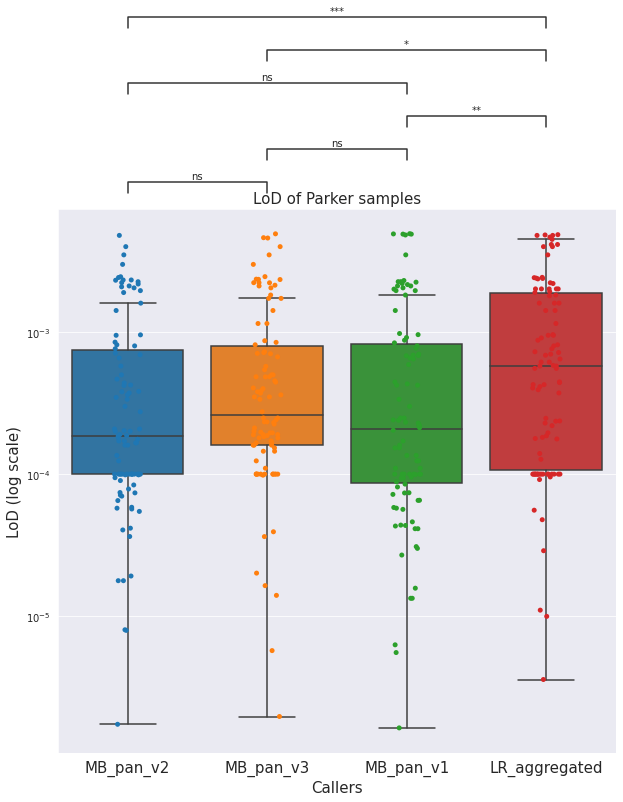

In [52]:
from statannotations.Annotator import Annotator

def boxplot_LoD(df):
    
    fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10))
    sns.set_style('darkgrid')
    
    # Plotting the boxplot and stripplot with the specified order
    sns.boxplot(data=df, x="Caller_Type", y="LoD", ax=ax0, showfliers=False)
    sns.stripplot(data=df, x="Caller_Type", y="LoD", jitter=True, size=5, ax=ax0)
    
    #log scale
    ax0.set_yscale("log") 
    
    met_sites = df['Caller_Type'].unique()
    pairs = []
    
    for i, met_site in enumerate(met_sites):
        subgroup = df[df['Caller_Type'] == met_site]
        n = subgroup.shape[0]
        
        # Calculate median, CI, and SD
        median = subgroup['LoD'].median()
        sd = subgroup['LoD'].std()
        ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
        print(f'{met_site}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
        
        # Create pairs for statistical annotation
        for other_met_site in met_sites[i+1:]:
            pairs.append((met_site, other_met_site))
    
    # Creating an Annotator object and adding statistical annotation
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD')
    # annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # Setting other plot properties
    plt.title('LoD of Parker samples', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    plt.show()

boxplot_LoD(df_lod_plot)

Series([], Name: treatment, dtype: int64)
LR_aggregated - on-treatment: Median = 0.00069, SD = 0.00137, CI = (0.00011, 0.00127)
LR_aggregated - post-treatment: Median = 0.00069, SD = 0.00074, CI = (0.00035, 0.00103)
LR_aggregated - pre-treatment: Median = 0.00056, SD = 0.00153, CI = (0.00012, 0.00099)
MB_pan_v1 - on-treatment: Median = 0.00014, SD = 0.00143, CI = (-0.00047, 0.00074)
MB_pan_v1 - post-treatment: Median = 0.00017, SD = 0.00121, CI = (-0.00038, 0.00072)
MB_pan_v1 - pre-treatment: Median = 0.00023, SD = 0.00098, CI = (-0.00005, 0.00051)
MB_pan_v2 - on-treatment: Median = 0.00017, SD = 0.00080, CI = (-0.00017, 0.00051)
MB_pan_v2 - post-treatment: Median = 0.00019, SD = 0.00096, CI = (-0.00025, 0.00062)
MB_pan_v2 - pre-treatment: Median = 0.00020, SD = 0.00105, CI = (-0.00010, 0.00050)
MB_pan_v3 - on-treatment: Median = 0.00024, SD = 0.00134, CI = (-0.00032, 0.00081)
MB_pan_v3 - post-treatment: Median = 0.00037, SD = 0.00126, CI = (-0.00020, 0.00094)
MB_pan_v3 - pre-treatment

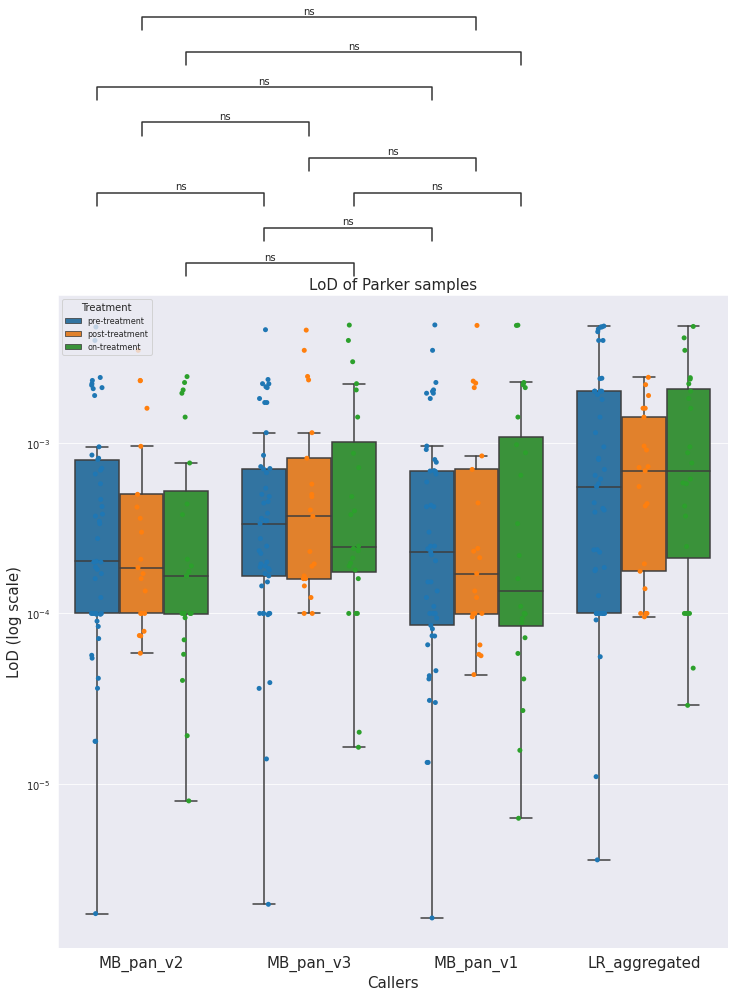

In [53]:
def boxplot_LoD_group(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="treatment", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="treatment", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('treatment')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    pairs = [
        (("MB_pan_v2", "pre-treatment"), ("MB_pan_v1", "pre-treatment")),
        (("MB_pan_v2", "on-treatment"), ("MB_pan_v1", "on-treatment")),
        (("MB_pan_v2", "post-treatment"), ("MB_pan_v1", "post-treatment")),

        (("MB_pan_v3", "pre-treatment"), ("MB_pan_v1", "pre-treatment")),
        (("MB_pan_v3", "on-treatment"), ("MB_pan_v1", "on-treatment")),
        (("MB_pan_v3", "post-treatment"), ("MB_pan_v1", "post-treatment")),

        (("MB_pan_v2", "pre-treatment"), ("MB_pan_v3", "pre-treatment")),
        (("MB_pan_v2", "on-treatment"), ("MB_pan_v3", "on-treatment")),
        (("MB_pan_v2", "post-treatment"), ("MB_pan_v3", "post-treatment")),
    ]
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='treatment')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of Parker samples', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:3], labels[0:3], title='Treatment', loc='upper left', fontsize = 8)  # Adjust depending on your number of categories

    plt.show()

df_lod_plot_treat = df_lod_plot[df_lod_plot["treatment"] != "uncertain"]
print(df_lod_plot_treat[df_lod_plot_treat["Caller_Type"] == "MB_pan"].treatment.value_counts())
boxplot_LoD_group(df_lod_plot_treat)

LR_aggregated - Bladder cancer: Median = 0.00072, SD = 0.00076, CI = (0.00014, 0.00130)
LR_aggregated - Breast cancer: Median = 0.00039, SD = 0.00075, CI = (-0.00054, 0.00132)
LR_aggregated - Colon cancer: Median = 0.00062, SD = 0.00060, CI = (0.00006, 0.00117)
LR_aggregated - Gastroesophageal cancer: Median = 0.00010, SD = 0.00185, CI = (-0.00161, 0.00181)
LR_aggregated - Prostate cancer: Median = 0.00018, SD = 0.00181, CI = (-0.00207, 0.00242)
LR_aggregated - Small cell lung cancer: Median = 0.00059, SD = 0.00076, CI = (-0.00022, 0.00139)
LR_aggregated - other: Median = 0.00076, SD = 0.00150, CI = (0.00037, 0.00115)
MB_pan_v1 - Bladder cancer: Median = 0.00034, SD = 0.00080, CI = (-0.00028, 0.00095)
MB_pan_v1 - Breast cancer: Median = 0.00016, SD = 0.00026, CI = (-0.00017, 0.00049)
MB_pan_v1 - Colon cancer: Median = 0.00006, SD = 0.00004, CI = (0.00002, 0.00010)
MB_pan_v1 - Gastroesophageal cancer: Median = 0.00010, SD = 0.00011, CI = (-0.00000, 0.00020)
MB_pan_v1 - Prostate cancer: 

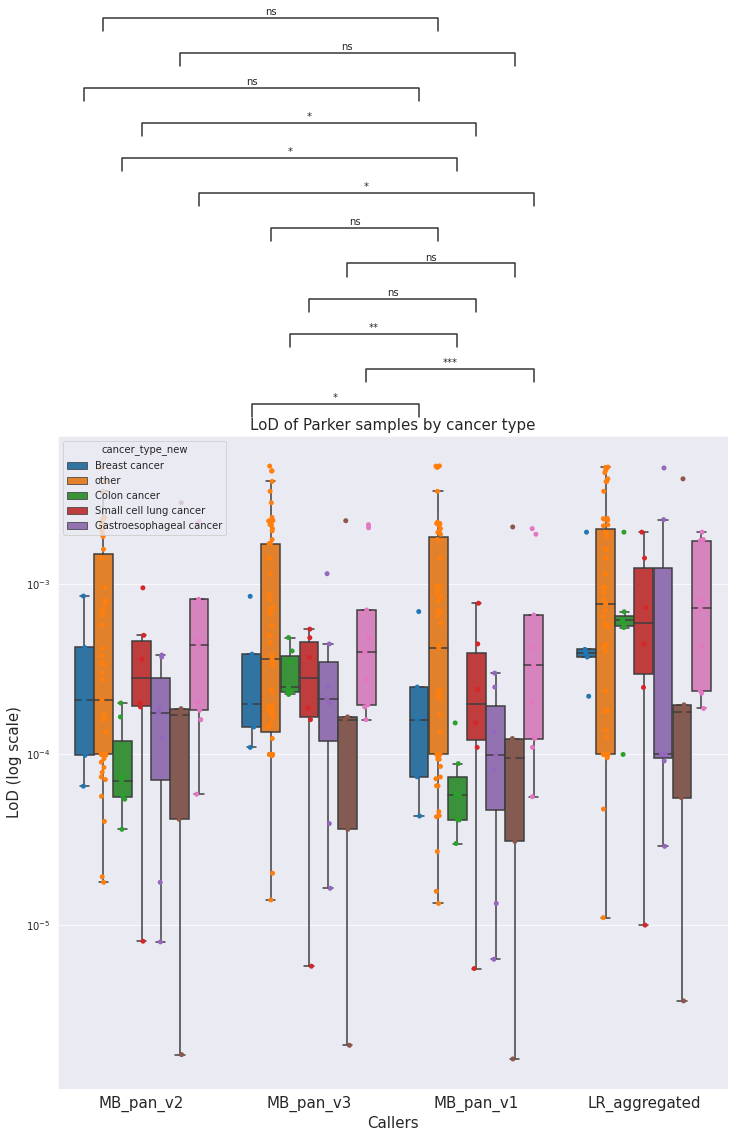

In [55]:
def boxplot_LoD_cancer_parker(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type_new", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type_new", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('cancer_type_new')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    pairs = [
        (("MB_pan_v1", "Bladder cancer"), ("MB_pan_v2", "Bladder cancer")),
        (("MB_pan_v1", "Colon cancer"), ("MB_pan_v2", "Colon cancer")),
        (("MB_pan_v1", "Small cell lung cancer"), ("MB_pan_v2", "Small cell lung cancer")),
        (("MB_pan_v1", "Breast cancer"), ("MB_pan_v2", "Breast cancer")),
        (("MB_pan_v1", "Prostate cancer"), ("MB_pan_v2", "Prostate cancer")),
        (("MB_pan_v1", "other"), ("MB_pan_v2", "other")),
    
        (("MB_pan_v1", "Bladder cancer"), ("MB_pan_v3", "Bladder cancer")),
        (("MB_pan_v1", "Colon cancer"), ("MB_pan_v3", "Colon cancer")),
        (("MB_pan_v1", "Small cell lung cancer"), ("MB_pan_v3", "Small cell lung cancer")),
        (("MB_pan_v1", "Breast cancer"), ("MB_pan_v3", "Breast cancer")),
        (("MB_pan_v1", "Prostate cancer"), ("MB_pan_v3", "Prostate cancer")),
        (("MB_pan_v1", "other"), ("MB_pan_v3", "other")),
    ]
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='cancer_type_new')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of Parker samples by cancer type', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:5], labels[0:5], title='cancer_type_new', loc='upper left', fontsize = 10)  # Adjust depending on your number of categories

    plt.show()

# df_lod_cancer = df_lod_plot[(df_lod_plot["cancer_type"] == "Bladder cancer") | (df_lod_plot["cancer_type"] == "Colon cancer") | (df_lod_plot["cancer_type"] == "Small cell lung cancer") | (df_lod_plot["cancer_type"] == "Breast cancer") | (df_lod_plot["cancer_type"] == "Prostate cancer")]
boxplot_LoD_cancer_parker(df_lod_plot)

Bladder cancer - LR_aggregated: Median = 0.00072, SD = 0.00076, CI = (0.00014, 0.00130)
Bladder cancer - MB_pan_v1: Median = 0.00034, SD = 0.00080, CI = (-0.00028, 0.00095)
Bladder cancer - MB_pan_v2: Median = 0.00044, SD = 0.00090, CI = (-0.00025, 0.00113)
Bladder cancer - MB_pan_v3: Median = 0.00040, SD = 0.00083, CI = (-0.00024, 0.00104)
Breast cancer - LR_aggregated: Median = 0.00039, SD = 0.00075, CI = (-0.00054, 0.00132)
Breast cancer - MB_pan_v1: Median = 0.00016, SD = 0.00026, CI = (-0.00017, 0.00049)
Breast cancer - MB_pan_v2: Median = 0.00021, SD = 0.00032, CI = (-0.00019, 0.00061)
Breast cancer - MB_pan_v3: Median = 0.00020, SD = 0.00030, CI = (-0.00018, 0.00058)
Colon cancer - LR_aggregated: Median = 0.00062, SD = 0.00060, CI = (0.00006, 0.00117)
Colon cancer - MB_pan_v1: Median = 0.00006, SD = 0.00004, CI = (0.00002, 0.00010)
Colon cancer - MB_pan_v2: Median = 0.00007, SD = 0.00006, CI = (0.00001, 0.00013)
Colon cancer - MB_pan_v3: Median = 0.00025, SD = 0.00010, CI = (0.0

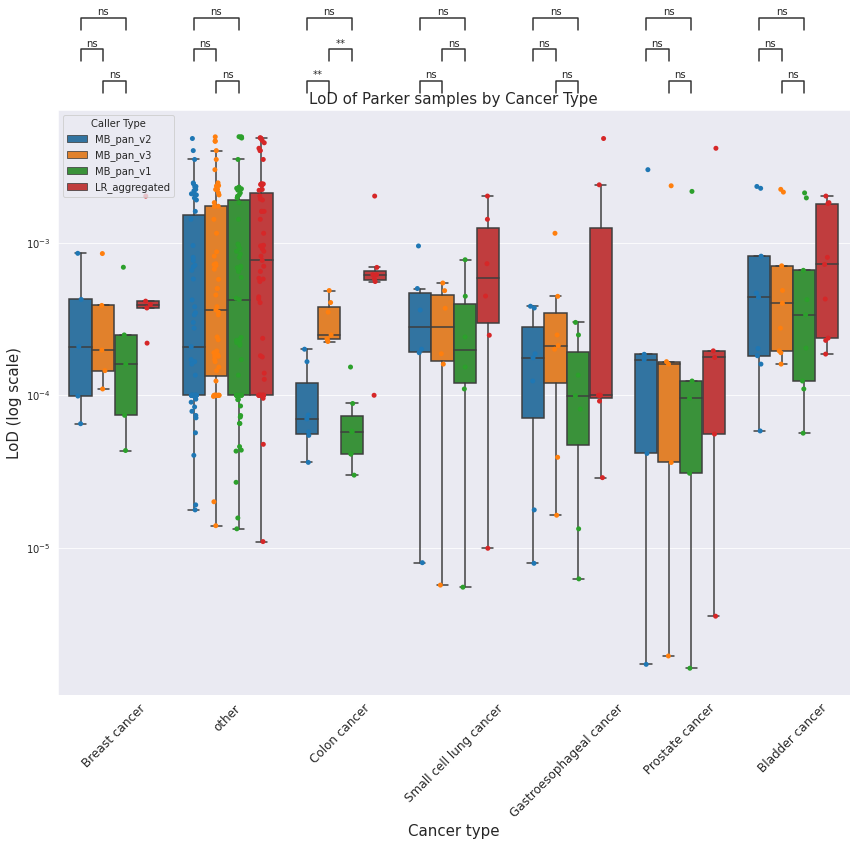

In [75]:
def boxplot_LoD_cancer_parker_new(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="cancer_type_new", y="LoD", hue="Caller_Type", ax=ax0, palette=palette, showfliers=False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="cancer_type_new", y="LoD", hue="Caller_Type", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log")
    
    # Adjusting for statistics
    for cancer_type, group in df.groupby('cancer_type_new'):
        for caller_type, subgroup in group.groupby('Caller_Type'):
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup)-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{cancer_type} - {caller_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    # Defining new pairs for within cancer type caller comparison
    cancer_types = df['cancer_type_new'].unique()
    caller_types = ["MB_pan_v1", "MB_pan_v2", "MB_pan_v3"]
    
    pairs = []
    for cancer_type in cancer_types:
        for i in range(len(caller_types)):
            for j in range(i+1, len(caller_types)):
                pairs.append(((cancer_type, caller_types[i]), (cancer_type, caller_types[j])))
    
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='cancer_type_new', y='LoD', hue='Caller_Type')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of Parker samples by Cancer Type', fontsize=15)
    ax0.set_xlabel('Cancer type', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, fontsize=12)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    # Assuming the first few handles and labels are for the cancer types; adjust as necessary
    ax0.legend(unique_handles[:len(caller_types) + 1], unique_labels[:len(caller_types) + 1], title='Caller Type', loc='upper left', fontsize=10)

    plt.tight_layout()
    plt.show()

boxplot_LoD_cancer_parker_new(df_lod_plot)

In [57]:
# Filter the DataFrame for pre-treatment and the two caller types
pre_treatment_data = df_lod_plot_treat[df_lod_plot_treat['treatment'] == 'on-treatment']
pan_eclipseIA_data = pre_treatment_data[pre_treatment_data['Caller_Type'] == 'MB_pan_v2']
pan_data = pre_treatment_data[pre_treatment_data['Caller_Type'] == 'MB_pan_v1']

# Ensure the data is sorted by 'run_sample_id' so that the pairs match
pan_eclipseIA_data = pan_eclipseIA_data.sort_values('run_sample_id')
pan_data = pan_data.sort_values('run_sample_id')

# Perform the paired t-test on matched pairs
# We use 'merge' to make sure we only compare the same 'run_sample_id'
merged_data = pd.merge(pan_eclipseIA_data, pan_data, on='run_sample_id', suffixes=('_pan_v2', '_pan_v1'))
t_stat, p_val = stats.ttest_rel(merged_data['LoD_pan_v2'], merged_data['LoD_pan_v1'])

print(f'T-statistic: {t_stat}, P-value: {p_val}')


T-statistic: -1.1668081200379372, P-value: 0.2552436240129189
